Veri Seti Boyutu: (284807, 31)

İlk 5 Satır:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -

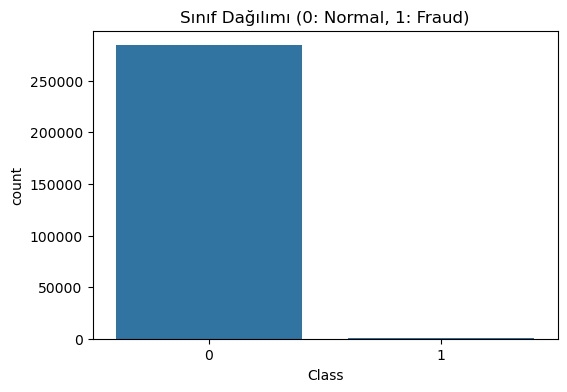

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Veri Setini Yükle
df = pd.read_csv('creditcard.csv')

# Veriye Genel Bakış
print("Veri Seti Boyutu:", df.shape)
print("\nİlk 5 Satır:")
print(df.head())

# Sınıf Dağılımı
class_counts = df['Class'].value_counts()
print("\nSınıf Dağılımı:")
print(class_counts)

print("\nFraud Oranı (%):", (class_counts[1] / len(df)) * 100)

# Görselleştirme
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Sınıf Dağılımı (0: Normal, 1: Fraud)')
plt.show()

In [7]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

# 'Time' sütununu çıkaralım
data = df.drop(['Time'], axis=1)

# 'Amount' sütununu ölçekleyelim 
# RobustScaler aykırı değerleri daha iyi yönetir
r_scaler = RobustScaler()
data['Amount'] = r_scaler.fit_transform(data['Amount'].values.reshape(-1,1))

# Bağımlı (y) ve Bağımsız (X) değişkenleri ayıralım
X = data.drop('Class', axis=1)
y = data['Class']

# Veriyi Eğitim (%80) ve Test (%20) olarak bölelim
# stratify=y -> Fraud oranını her iki parçada da korur
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Eğitim seti boyutu:", X_train.shape)
print("Test seti boyutu:", X_test.shape)
print("\nEğitim setindeki Fraud sayısı:", y_train.sum())
print("Test setindeki Fraud sayısı:", y_test.sum())

Eğitim seti boyutu: (227845, 29)
Test seti boyutu: (56962, 29)

Eğitim setindeki Fraud sayısı: 394
Test setindeki Fraud sayısı: 98



Random Forest Sonuçları
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.76      0.85        98

    accuracy                           1.00     56962
   macro avg       0.98      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962



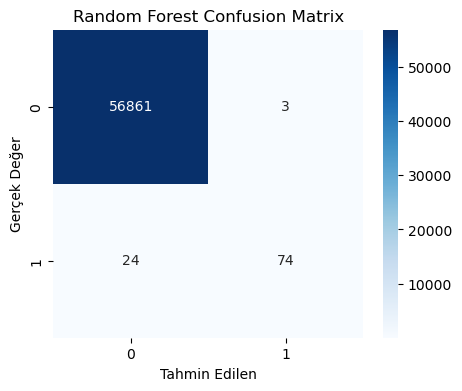

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Modelin Tanımlanması
rf_model = RandomForestClassifier(n_estimators=100,
                                  random_state=42,
                                  class_weight='balanced', # Dengesiz veri için kritik ayar
                                  n_jobs=-1)

# Modelin Eğitilmesi
rf_model.fit(X_train, y_train)

# Test Seti Üzerinde Tahmin
y_pred_rf = rf_model.predict(X_test)

# Sonuçların Raporlanması 
print("\nRandom Forest Sonuçları")
print(classification_report(y_test, y_pred_rf))

# Karmaşıklık Matrisi (Confusion Matrix)
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin Edilen')
plt.show()

In [ ]:
!pip install xgboost

Hesaplanan Ağırlık Katsayısı: 577.29

XGBoost Sonuçları
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.72      0.85      0.78        98

    accuracy                           1.00     56962
   macro avg       0.86      0.92      0.89     56962
weighted avg       1.00      1.00      1.00     56962



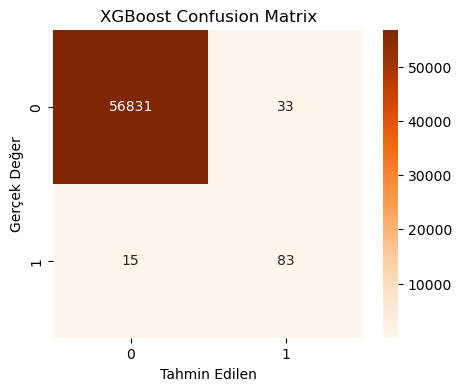

In [9]:
from xgboost import XGBClassifier

# Dengesizlik Oranını Hesapla (scale_pos_weight için)
# Normal İşlem Sayısı / Fraud Sayısı
neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
scale_weight = neg_count / pos_count
print(f"Hesaplanan Ağırlık Katsayısı: {scale_weight:.2f}")

# Model Tanımlama ve Eğitme
xgb_model = XGBClassifier(scale_pos_weight=scale_weight,
                          n_estimators=100,
                          learning_rate=0.1,
                          random_state=42,
                          eval_metric='logloss') # Uyarı almamak için metrik ekledik

xgb_model.fit(X_train, y_train)

# Tahmin Yap
y_pred_xgb = xgb_model.predict(X_test)

# Sonuçları Göster
print("\nXGBoost Sonuçları")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges')
plt.title('XGBoost Confusion Matrix')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin Edilen')
plt.show()

In [ ]:
!pip install tensorflow


YSA (MLPClassifier) Sonuçları
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.79      0.84        98

    accuracy                           1.00     56962
   macro avg       0.95      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962



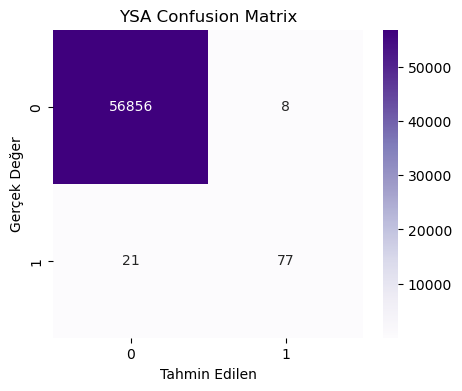

In [10]:
from sklearn.neural_network import MLPClassifier

# YSA Modelini Tanımla (Scikit-Learn versiyonu)
# hidden_layer_sizes=(32, 16): İlk gizli katmanda 32, ikincide 16 nöron olsun.
# max_iter=100: 100 epoch (tur) dönsün.
ysa_model = MLPClassifier(hidden_layer_sizes=(32, 16),
                          activation='relu',
                          solver='adam',
                          random_state=42,
                          max_iter=100)

# Modeli Eğitme
ysa_model.fit(X_train, y_train)

# Test Seti Üzerinde Tahmin 
y_pred_ysa = ysa_model.predict(X_test)

# Sonuçların Raporlanması
print("\nYSA (MLPClassifier) Sonuçları")
print(classification_report(y_test, y_pred_ysa))

# Karmaşıklık Matrisi
cm_ysa = confusion_matrix(y_test, y_pred_ysa)
plt.figure(figsize=(5,4))
sns.heatmap(cm_ysa, annot=True, fmt='d', cmap='Purples')
plt.title('YSA Confusion Matrix')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin Edilen')
plt.show()